# **DATA PREPROCESSING**

In [1]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF #
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/dataset.zip'

In [8]:
target_size = (256, 256)
resize_transform = T.Resize(target_size, interpolation=Image.NEAREST)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [9]:
class VOCSegmentationDataset(Dataset):
    def __init__(self, filenames, image_dir, mask_dir, resize_transform, normalize_transform, object_class_ids):
        self.filenames = filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize_transform = resize_transform
        self.normalize_transform = normalize_transform
        self.object_class_ids = object_class_ids

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        image = self.resize_transform(image)
        mask = self.resize_transform(mask)

        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        rotation_degrees = random.randint(-10, 10)
        image = TF.rotate(image, rotation_degrees)
        mask = TF.rotate(mask, rotation_degrees)

        mask_np = np.array(mask)
        binary_mask = np.zeros_like(mask_np, dtype=np.float32)

        for obj_id in self.object_class_ids:
            binary_mask[mask_np == obj_id] = 1

        image = T.ToTensor()(image)
        image = self.normalize_transform(image)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)

        return image, binary_mask


In [13]:
random.seed(42)
random.shuffle(images_with_any_object)
train_split = int(len(images_with_any_object) * 0.8)
val_split = int(len(images_with_any_object) * 0.1)

train_filenames = images_with_any_object[:train_split]
val_filenames = images_with_any_object[train_split:train_split + val_split]
test_filenames = images_with_any_object[train_split + val_split:]

train_dataset = VOCSegmentationDataset(train_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)
val_dataset = VOCSegmentationDataset(val_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)
test_dataset = VOCSegmentationDataset(test_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


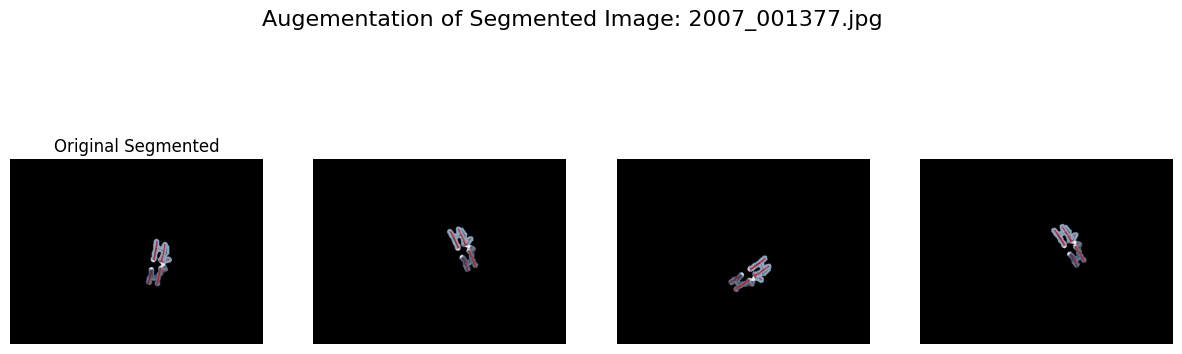

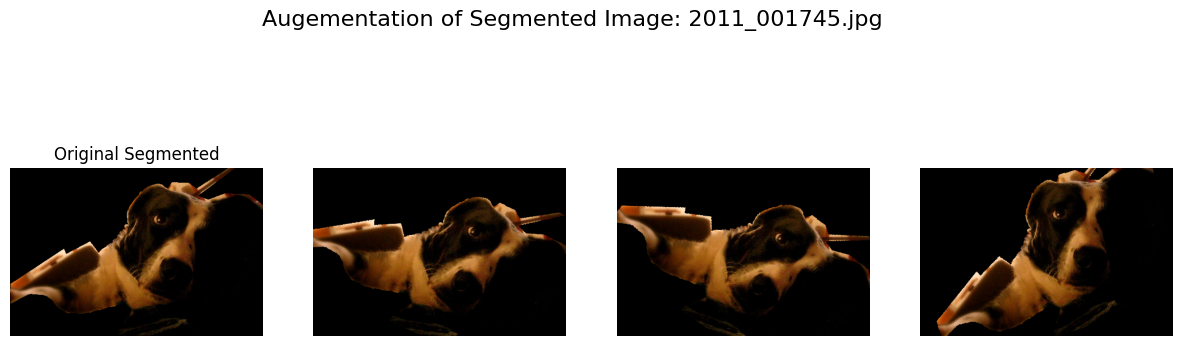

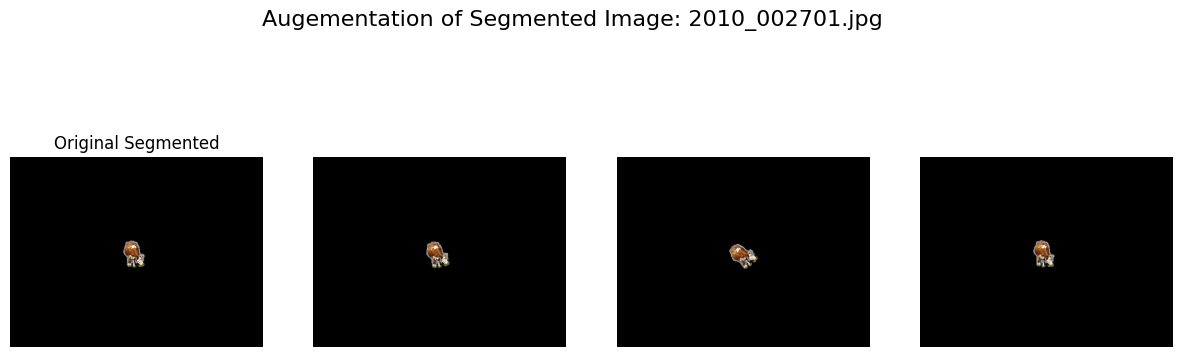

In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

object_class_ids = list(range(1, 21))

if not images_with_any_object:
    print("No images with objects were found to visualize.")
else:
    images_to_display = random.sample(images_with_any_object, min(3, len(images_with_any_object)))

    for image_name in images_to_display:
        image_path = os.path.join(image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(mask_dir, mask_name)

        try:
            original_image = Image.open(image_path).convert("RGB")
            original_mask = Image.open(mask_path)

            mask_np = np.array(original_mask)
            all_objects_mask = (mask_np != 0)

            segmented_image_np = np.zeros_like(np.array(original_image))
            segmented_image_np[all_objects_mask] = np.array(original_image)[all_objects_mask]

            segmented_image_pil = Image.fromarray(segmented_image_np.astype(np.uint8))

            fig, axes = plt.subplots(1, 4, figsize=(15, 5))
            fig.suptitle(f'Augementation of Segmented Image: {image_name}', fontsize=16)

            axes[0].imshow(segmented_image_pil)
            axes[0].set_title('Original Segmented')
            axes[0].axis('off')

            for i in range(3):
                rotation_degrees = random.randint(-45, 45)
                rotated_image = F.rotate(segmented_image_pil, rotation_degrees)

                axes[i+1].imshow(rotated_image)
                ##axes[i+1].set_title(f'Rotated by {rotation_degrees}°')
                axes[i+1].axis('off')

            plt.show()

        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

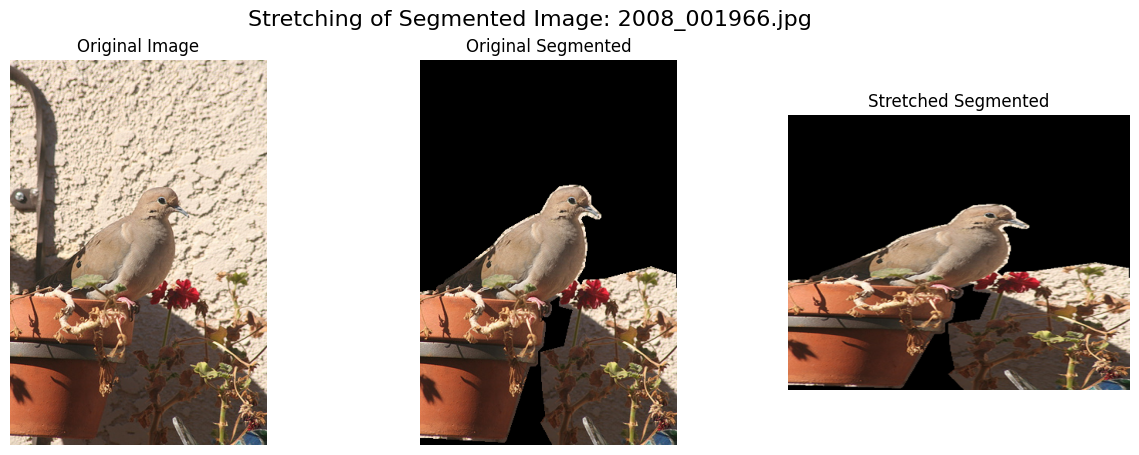

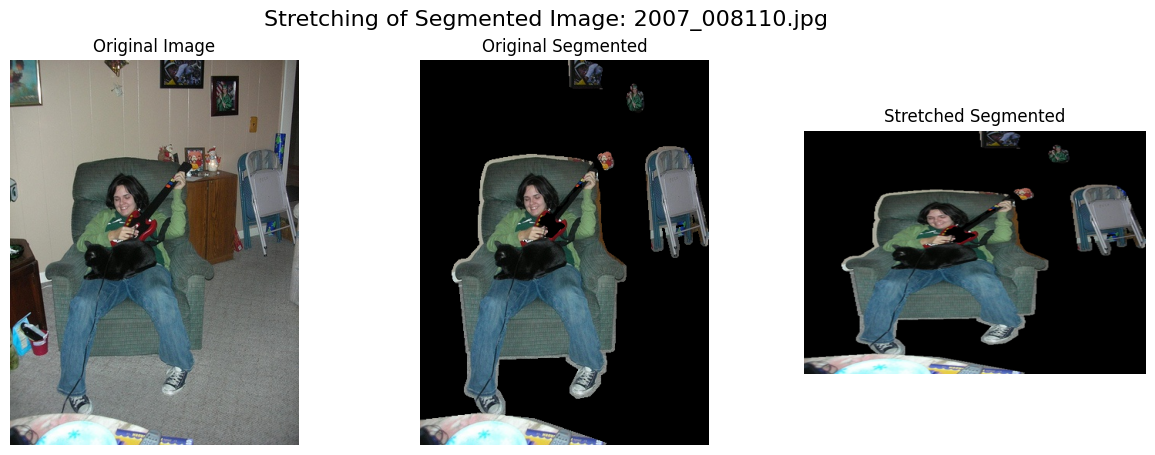

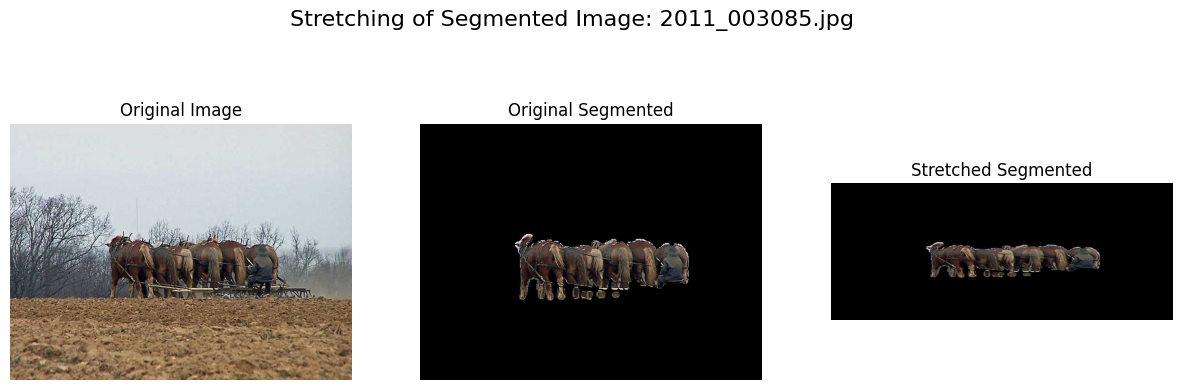

In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

if not images_with_any_object:
    print("No images with objects were found to visualize.")
else:
    images_to_display = random.sample(images_with_any_object, min(3, len(images_with_any_object)))

    for image_name in images_to_display:
        image_path = os.path.join(image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(mask_dir, mask_name)

        try:
            original_image = Image.open(image_path).convert("RGB")
            original_mask = Image.open(mask_path)

            mask_np = np.array(original_mask)
            all_objects_mask = (mask_np != 0)

            segmented_image_np = np.zeros_like(np.array(original_image))
            segmented_image_np[all_objects_mask] = np.array(original_image)[all_objects_mask]

            segmented_image_pil = Image.fromarray(segmented_image_np.astype(np.uint8))

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'Stretching of Segmented Image: {image_name}', fontsize=16)

            axes[0].imshow(original_image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(segmented_image_pil)
            axes[1].set_title('Original Segmented')
            axes[1].axis('off')

            stretched_image = segmented_image_pil.resize((int(segmented_image_pil.width * 1.5), int(segmented_image_pil.height * 0.8)))
            axes[2].imshow(stretched_image)
            axes[2].set_title('Stretched Segmented')
            axes[2].axis('off')

            plt.show()

        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

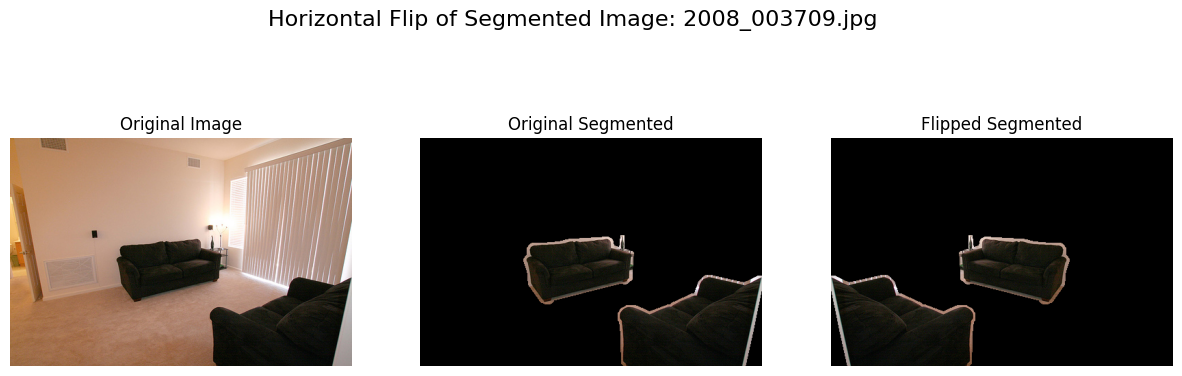

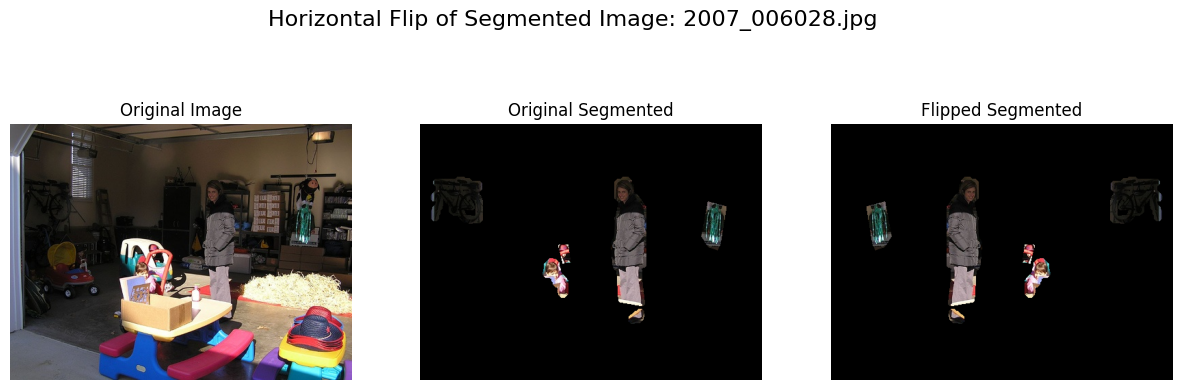

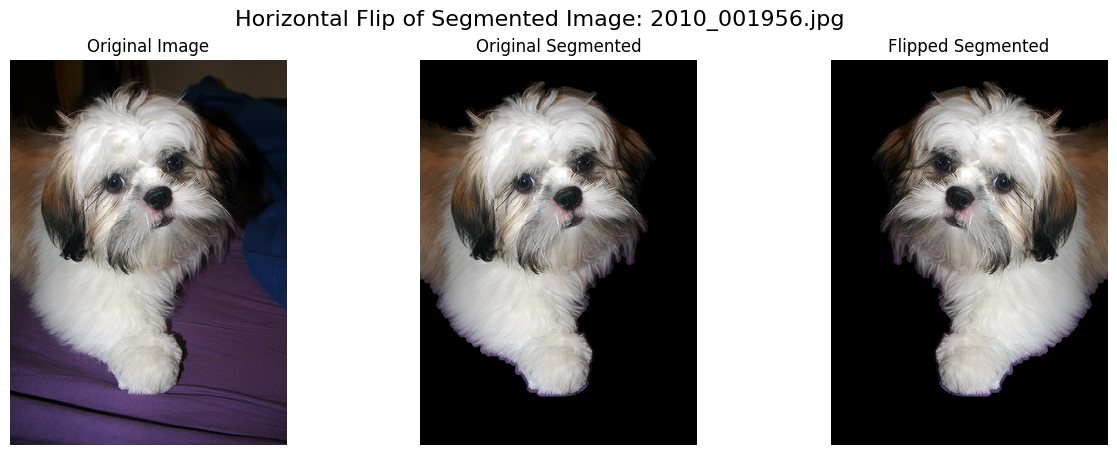

In [18]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F

if not images_with_any_object:
    print("No images with objects were found to visualize.")
else:
    images_to_display = random.sample(images_with_any_object, min(3, len(images_with_any_object)))

    for image_name in images_to_display:
        image_path = os.path.join(image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(mask_dir, mask_name)

        try:
            original_image = Image.open(image_path).convert("RGB")
            original_mask = Image.open(mask_path)

            mask_np = np.array(original_mask)
            all_objects_mask = (mask_np != 0)

            segmented_image_np = np.zeros_like(np.array(original_image))
            segmented_image_np[all_objects_mask] = np.array(original_image)[all_objects_mask]

            segmented_image_pil = Image.fromarray(segmented_image_np.astype(np.uint8))

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'Horizontal Flip of Segmented Image: {image_name}', fontsize=16)

            axes[0].imshow(original_image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(segmented_image_pil)
            axes[1].set_title('Original Segmented')
            axes[1].axis('off')

            flipped_image = F.hflip(segmented_image_pil)
            axes[2].imshow(flipped_image)
            axes[2].set_title('Flipped Segmented')
            axes[2].axis('off')

            plt.show()

        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# **BINARY SEGMENTATION**

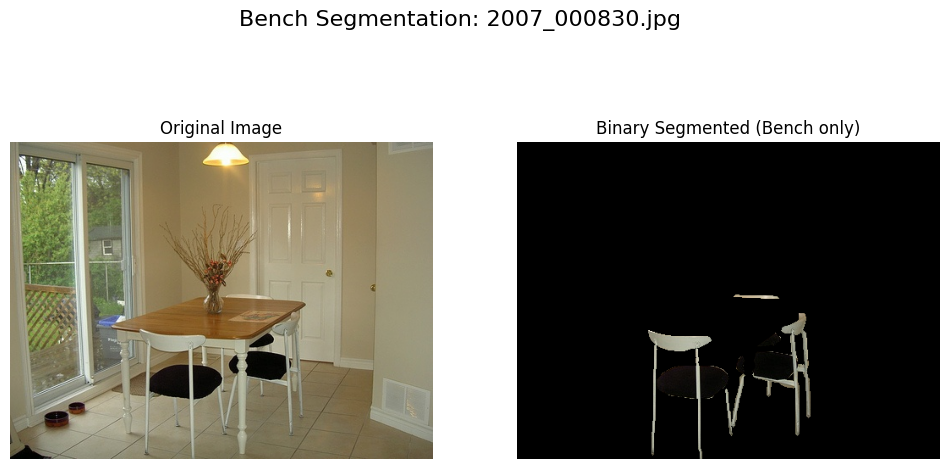

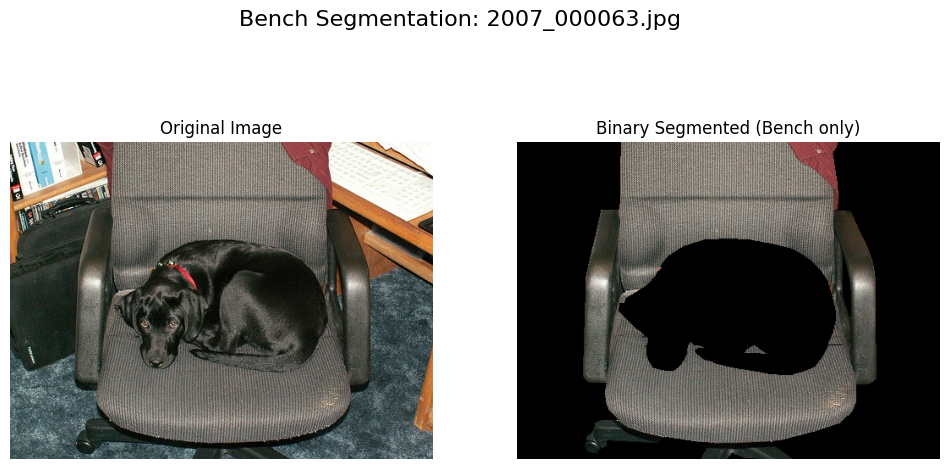

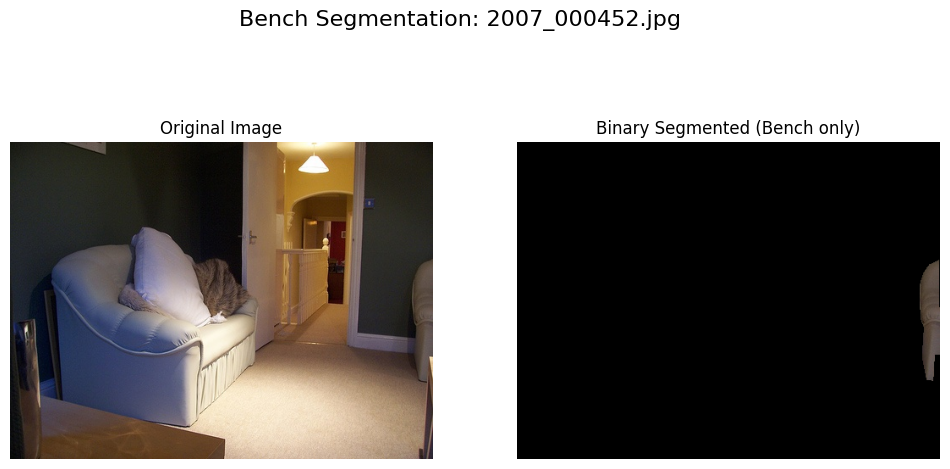

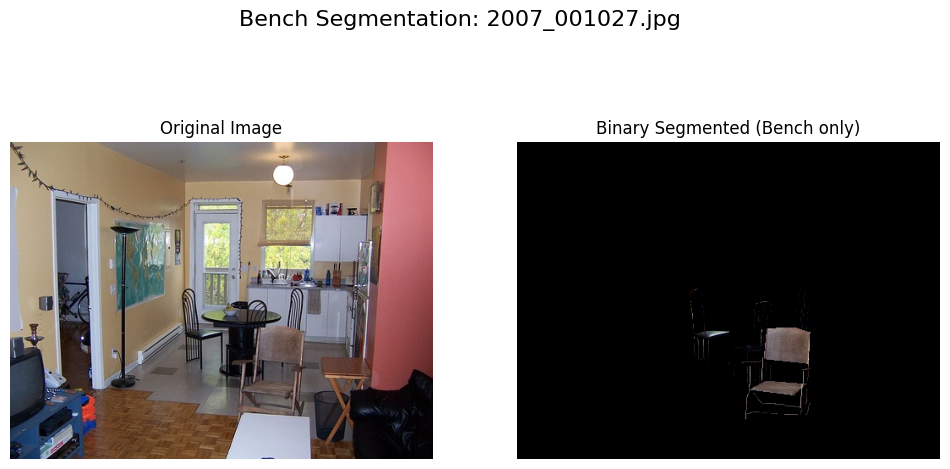

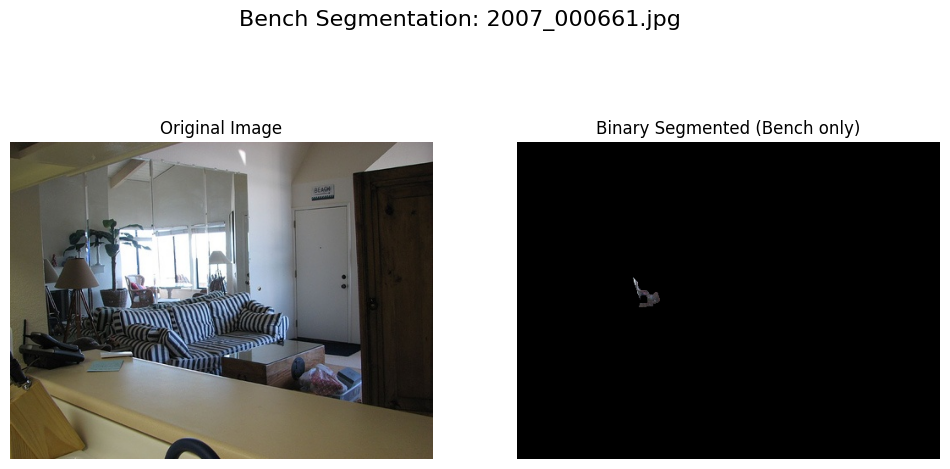

In [21]:
all_image_names = sorted(os.listdir(image_dir))
images_with_bench = []
bench_class_id = 10

count = 0
for image_name in all_image_names:
    mask_name = image_name.replace('.jpg', '.png')
    mask_path = os.path.join(mask_dir, mask_name)

    if os.path.exists(mask_path):
        try:
            mask = Image.open(mask_path)
            mask_np = np.array(mask)

            if bench_class_id in np.unique(mask_np):
                images_with_bench.append(image_name)
                count += 1
                if count >= 10:
                    break
        except Exception:
            continue


if not images_with_bench:
    print("No images with benches found. Please run the filtering step first.")
else:
    images_to_display = random.sample(images_with_bench, min(5, len(images_with_bench)))

    for image_name in images_to_display:
        image_path = os.path.join(image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(mask_dir, mask_name)

        try:
            original_image = Image.open(image_path).convert("RGB")
            original_mask = Image.open(mask_path)

            mask_np = np.array(original_mask)

            bench_binary_mask = (mask_np == bench_class_id).astype(np.uint8)

            segmented_bench_np = np.zeros_like(np.array(original_image))
            segmented_bench_np[bench_binary_mask == 1] = np.array(original_image)[bench_binary_mask == 1]

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle(f'Bench Segmentation: {image_name}', fontsize=16)

            ax[0].imshow(original_image)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(segmented_bench_np)
            ax[1].set_title('Binary Segmented')
            ax[1].axis('off')

            plt.show()

        except Exception as e:
            print(f"Failed to process {image_name}: {e}")